In [1]:
%matplotlib inline

from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from numpy.fft import fft2, ifft2, fftshift, fftfreq
from bruges.transform import time_to_depth, depth_to_time
from scipy.interpolate import CubicSpline, interp1d, interp2d
from scipy.signal import coherence
from ipywidgets import interact_manual, FloatSlider, interact
from IPython.display import HTML, display

In [114]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<font size="6" color="red">The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.</font>''')

### Defining our NMO correction functions and other helper functions
The functions nmo_correction, reflection_time, and sample_trace come courtesy of Leonardo Uieda and his geophysical tutorial "Step-by-step NMO correction" published in The Leading Edge. They have be refactored to run faster for this demo.

    Step-by-step NMO correction
    Uieda,Leonardo
    The Leading Edge(2017),36(2):179
    http://dx.doi.org/10.1190/tle36020179.1

In [33]:
def nmo_vectorized(cmp, dt, offsets, velocities):
    '''
    Vectorized implementation of Leonardo Uieda's NMO functions 
    
    Step-by-step NMO correction
    Uieda,Leonardo
    The Leading Edge(2017),36(2):179
    http://dx.doi.org/10.1190/tle36020179.1
    
    '''
    nsamples = cmp.shape[0]
    times = np.arange(0, nsamples*dt, dt)
    
    t = reflection_time_vectorized(cmp, times, offsets, velocities)
    
    #flatten for efficiency 
    cmp_flat = cmp.flatten(order='F')
    nmo_flat = np.zeros_like(cmp_flat)

    samps = np.floor(t / dt).astype(int).T
    samps_reindex = np.zeros_like(samps)
    
    # this re-indexing makes sure the index values are numbered correctly
    # for the flattened array.
    for i in range(samps.shape[0]):
        samps_reindex[i] = samps[i] + samps.shape[1] * i 

    samps_reindex_flat = samps_reindex.flatten(order='F') 

    N_flat = samps_reindex_flat.shape[0]

    for i, j in enumerate(samps_reindex_flat):
        if j < 0 or j >= N_flat:
            nmo_flat[i] = None
        else:
            nmo_flat[i] = cmp_flat[j]
    
    nmo = nmo_flat.reshape(cmp.shape[0], cmp.shape[1])
    
    return nmo
    
    
    

In [3]:
def reflection_time_vectorized(cmp, t0, offsets, vnmo):
    """
    Calculate the travel-time of a reflected wave.
    
    Doesn't consider refractions or changes in velocity.
        
    The units must be consistent. E.g., if t0 is seconds and
    x is meters, vnmo must be m/s.
    
    Parameters
    ----------
    
    t0 : float
        The 0-offset (normal incidence) travel-time. 1D array
    x : float
        The offset of the receiver. 1D array
    vnmo : float
        The NMO velocity. 1D array
        
    Returns
    -------
    
    t : float
        The reflection travel-time 2D array
        
    """
    nsamples = cmp.shape[0]
    
    t0_sq = np.ones_like(cmp) * (t0**2).reshape(nsamples,1)
    vnmo_sq = np.ones_like(cmp) * (vnmo**2).reshape(nsamples,1)
    x_sq = np.ones_like(cmp) * offsets**2
    
    t = np.sqrt(t0_sq + x_sq/vnmo_sq)
    
    return t
    

In [4]:
def calc_angles(v_rms, time, x):
    '''
    Calculate the angle of incidence of an NMO corrected reflection.
    Ray-bending is not accounted for.
    
    Parameters
    ----------
    
    v_rms : RMS velocity at some point
    time : twt time from the gather
    x : offset
    '''
#     if type(v_rms).__module__ == np.__name__ && type(time).__module__ == np.__name__ && type(x).__module__ == np.__name__
    v_rms = np.array(v_rms)
    time = np.array(time)
    x = np.array(x)
    
    depth = v_rms * time
    angles = 90 - np.degrees(np.arctan(depth / x))
       
    return angles
    

In [5]:
def reflection_time(t0, x, vnmo):
    """
    Calculate the travel-time of a reflected wave.
    
    Doesn't consider refractions or changes in velocity.
        
    The units must be consistent. E.g., if t0 is seconds and
    x is meters, vnmo must be m/s.
    
    Parameters
    ----------
    
    t0 : float
        The 0-offset (normal incidence) travel-time.
    x : float
        The offset of the receiver.
    vnmo : float
        The NMO velocity.
        
    Returns
    -------
    
    t : float
        The reflection travel-time.
        
    """
    t = np.sqrt(t0**2 + x**2/vnmo**2)
    return t

### Dix Conversion Equation
We are going to want to use our stacking velocity to calculate interval velocities in order to estimate pressure. We will use the fact that, for small offsets, stacking velocities are very similar to RMS velocities. It is, however, important to remember that $V_{RMS} \neq V_{Stacking}$ everywhere, and that these differences can be important.

**Dix Equation Assumptions**
* Layer boundaries are flat
* The offset range used in estimating the RMS velocities $V_{n}$ and $V_{n-1}$ corresponds to a small spread (i.e. short offsets)
* RMS velocities are calculated using a straight ray assuption, therefore ray-bending is not accounted for 

$$v_n = \sqrt{\frac{{V_n}^2 t_n - V_{n-1}^2 t_{n-1}}{t_n - t_{n-1}}}$$

In [6]:
def dix_eq(vrms, twt):
    int_vel = [np.sqrt((twt[i] * vrms[i]**2 - twt[i-1] * vrms[i-1]**2) / (twt[i] - twt[i-1])) for i in range(1,len(vrms))]
    return int_vel

#### Load in our synthetic CMP with known velocity model
Note: The geometrical spreading correction here was to simply multiply the CMP by TWT value

In [7]:
data = np.load(r"C:\Users\Thomas Cowan\OneDrive\_data\cmp_info_2200m.npz")
display(DataFrame(data.keys()).rename(index=str, columns={0: "Data in archive"}))

,Data in archive
0,velocity_model
1,density_model
2,offsets
3,cmp_orig
4,cmp_geom_sprd
5,dz
6,dt
7,reciever_loc
8,shot_loc
9,twt


##### Next we can split the archive into its component arrays.

In [85]:
cmp_vel_mod = data['velocity_model']
cmp_orig = data['cmp_orig']
cmp_geom_sprd = data['cmp_geom_sprd']
cmp_density_mod = data['density_model']
dz = data['dz']
dt = data['dt']
shot_loc = data['shot_loc']
offsets = data['offsets']
reciever_loc = data['reciever_loc']
twt = data['twt']
vnmo_trials = data['vnmo_trials'] 
vnmo_trial_vels = data['vnmo_trial_vels']

# cmp_geom_sprd = cmp_orig * twt.reshape(len(twt), 1)

lim_geom = np.percentile(cmp_geom_sprd, 99)
lim_cmp = np.percentile(cmp_orig, 99)

### Let's plot up the geometrical spreading corrected CMP

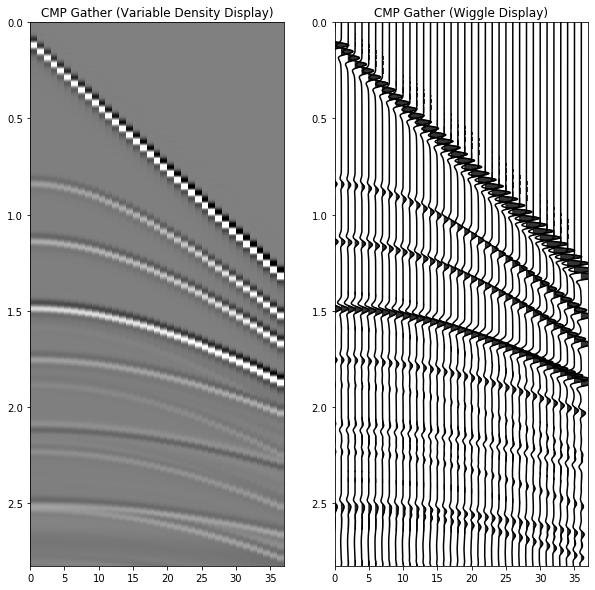

In [8]:
gain = 5
lim_geom = np.percentile(data['cmp_geom_sprd'], 99)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
titles = ['CMP Gather (Variable Density Display)', 'CMP Gather (Wiggle Display)']

extent = [0, data['cmp_geom_sprd'].shape[1], data['twt'].max(), 0]
ax[0].imshow(data['cmp_geom_sprd'], aspect='auto', vmin=-lim_geom, vmax=lim_geom, cmap='gray', extent=extent)

for i,a in enumerate(ax):
    a.set_title(titles[i])   

for i in range(data['cmp_geom_sprd'].shape[1]):
    ax[1].plot(data['cmp_geom_sprd'][:,i] * gain + i, data['twt'], c='k')
    ax[1].fill_betweenx(data['twt'], i, data['cmp_geom_sprd'][:,i] * gain + i, where=data['cmp_geom_sprd'][:,i] * gain + i > i, 
                        color='k', alpha=0.8, interpolate=True)
    
ax[1].set_ylim(0,data['twt'].max())
ax[1].set_xlim(0,data['cmp_geom_sprd'].shape[1])
ax[1].invert_yaxis()

### Now we will plot up the earth model this synthetic CMP came from

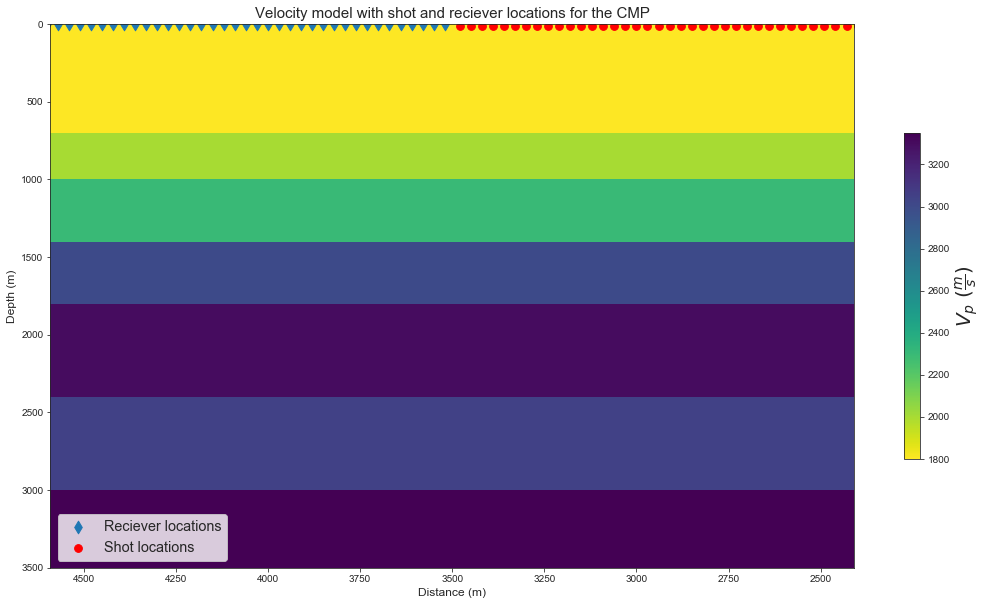

In [11]:
sns.set_style(style='ticks')

plt.figure(figsize=(18,10))
plt.scatter(data['reciever_loc'] * data['dz'],np.ones_like(data['shot_loc']), marker='d', s=80, label='Reciever locations')
plt.scatter(data['shot_loc'] * data['dz'],np.ones_like(data['shot_loc'])*10, s=60, color='r', label='Shot locations')
plt.xlim(data['reciever_loc'].max() * data['dz'] - data['dz'], data['shot_loc'].min() * data['dz'] + data['dz'])
plt.imshow(data['velocity_model'], extent=[data['reciever_loc'].max() * data['dz'] - data['dz'], data['shot_loc'].min() * data['dz'] + data['dz'], 3500, 0], 
           aspect='auto', cmap='viridis_r')
plt.xlabel('Distance (m)', size=12)
plt.ylabel('Depth (m)', size=12)
plt.title('Velocity model with shot and reciever locations for the CMP', size=15)
cb = plt.colorbar(shrink=0.6)
cb.set_label(label=r'$V_p \ (\frac{m}{s})$', weight='bold', size=20)

plt.legend(loc='lower left', fancybox=True, facecolor='w', frameon=True, fontsize='x-large')

In [21]:
def vel_mod():
    interface_depths = [0, 700, 1000, 1400, 1800, 2400, 3000]
    int_vels = [1800, 2000, 2300, 3000, 3300, 3050, 3350]
    layer_diff = np.diff(interface_depths)
    twt_vel_mod_1 = np.cumsum([(l * 2) / v for v,l in zip(int_vels,layer_diff)])
    twt_vel_mod_1 = np.insert(twt_vel_mod_1,0,0.)
    twt_vel_mod = [reflection_time(twt_vel_mod_1[i],data['offsets'][0], v) for i,v in enumerate(int_vels)]
    shape=(3500,)
    velocity = np.zeros(shape)
    for d,v in zip(interface_depths, int_vels):
#         velocity[int(d // 10):,:] = v
        velocity[d:] = v
    return velocity, twt_vel_mod

### A library of gathers corrected for different constant Vnmo values.

The data archive we loaded contained two items called "vnmo_trial_vels" and "vnmo_trials." These refer to a list of some constant test velocities and an array of the resulting corrected CMP gathers corrected with each velocity. 
We will use this library to do our stacking velocity analysis.

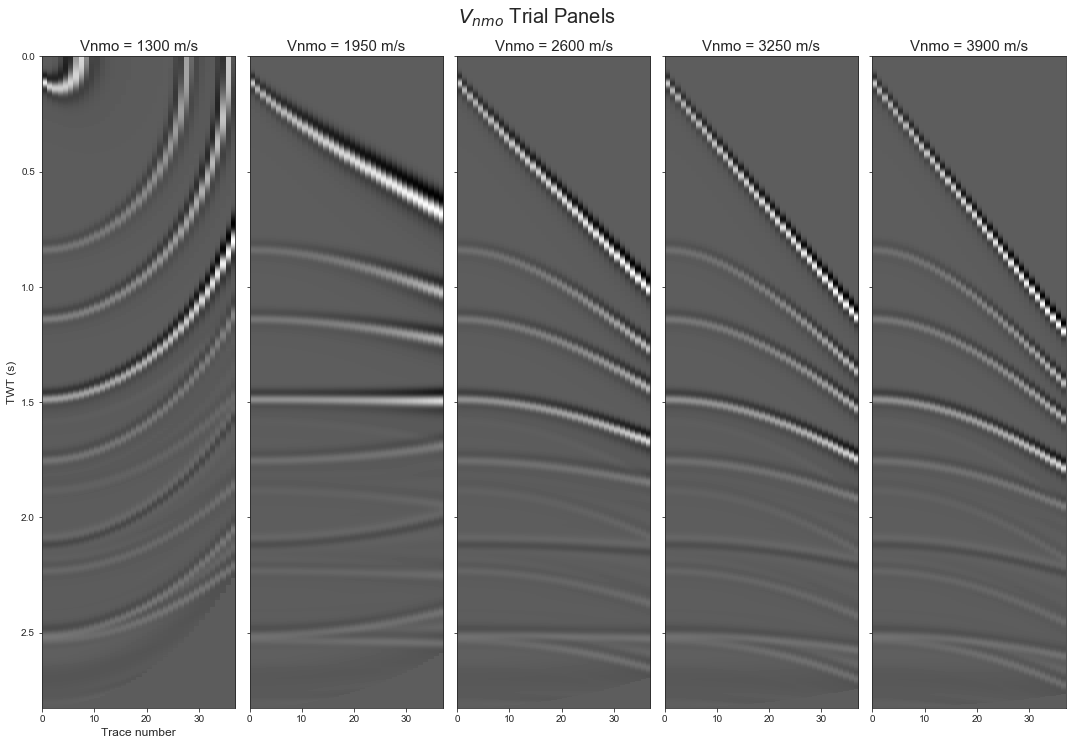

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,10), sharey=True, sharex=True)

vnmo_trial_vels = data['vnmo_trial_vels']

for i,j in enumerate(range(0,data['vnmo_trials'].shape[0],data['vnmo_trials'].shape[0] // 4)):
    ax[i].imshow(data['vnmo_trials'][j], aspect = 'auto', cmap='gray', extent=extent)
    ax[i].set_title(f'Vnmo = {vnmo_trial_vels[j]} m/s', size=15)
   
fig.suptitle(r'$V_{nmo}$ Trial Panels', y=1.03, size=20)
ax[0].set_ylabel('TWT (s)', size=12)
ax[0].set_xlabel('Trace number', size=12)
plt.tight_layout()

### We can stack each of the above panels into a single trace to better determine which velocities  best flatten certain reflections reflections. This is the most simple form of a velocity semblance window used for NMO velocity analysis.

In [14]:
def basic_semblance(vnmo_trials):
    sq_sum = np.array([np.sum(vnmo, axis=1)**2 for vnmo in vnmo_trials])
    summed_sqs = np.array([np.sum(vnmo**2, axis=1) for vnmo in vnmo_trials]) 
    n = vnmo_trials.shape[2]

    semblance = (sq_sum / summed_sqs) / n
    
    return semblance.T


$$semblance = \frac{\bigg( \sum_{i=1}^N a_i \bigg)^2}{N \sum_{i=1}^N a_i^2}$$

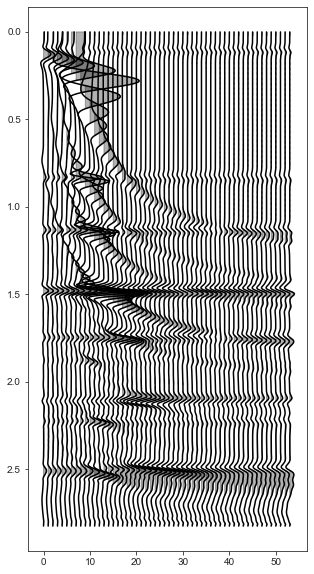

In [15]:
plt.figure(figsize=(5,10))

for i,v in enumerate(data['vnmo_trials']):
    plt.plot(np.sum(v, axis=1)+i, data['twt'], color='k')
    plt.fill_betweenx(data['twt'],i,np.sum(v, axis=1)+i,where=np.sum(v, axis=1)+i > i, 
                      color='k', alpha=0.3, interpolate=True)
plt.gca().invert_yaxis()


C:\Users\Thomas Cowan\.conda\envs\geocomp\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\Thomas Cowan\.conda\envs\geocomp\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in greater
C:\Users\Thomas Cowan\.conda\envs\geocomp\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in less
C:\Users\Thomas Cowan\.conda\envs\geocomp\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in greater


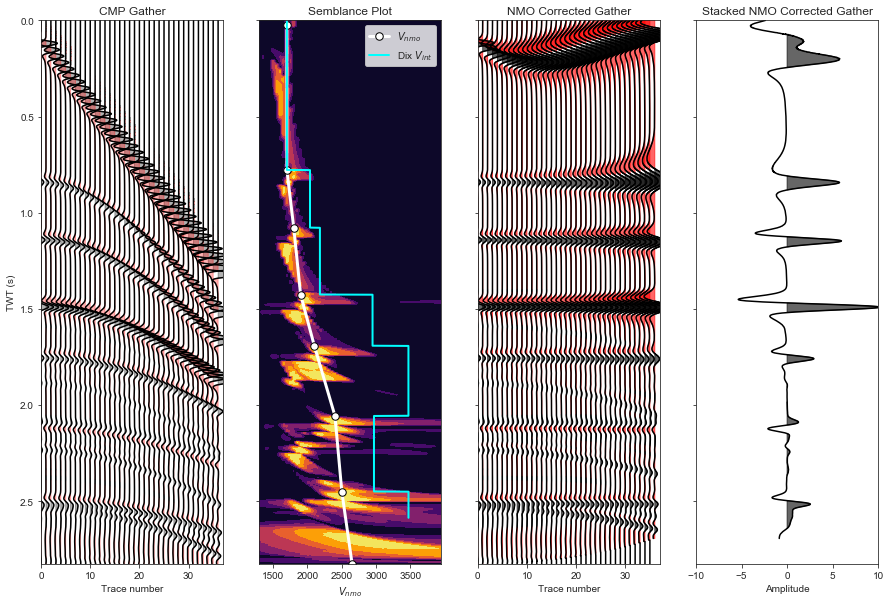

In [50]:
vnmo_correct, twt_vnmo, nmo_corr_gath = interact_plot_vector(1700, 1700, 1800, 1900,2100,2400,2500,2650)

In [49]:
def interact_plot_vector(v0,v1,v2,v3,v4,v5,v6,v7):
    
    real_vel, twt_vel_mod = vel_mod()
    real_vel_twt, t_basis = depth_to_time(real_vel, real_vel, dz=1,dt=data['dt'], return_t=True)
    real_vel_twt = real_vel_twt[:data['cmp_geom_sprd'].shape[0]]
    t_basis = t_basis[:data['cmp_geom_sprd'].shape[0]]
    
    gain = 8
    titles = ['CMP Gather', 'Semblance Plot', 'NMO Corrected Gather', 'Stacked NMO Corrected Gather']
    x_labels = ['Trace number', r'$V_{nmo}$', 'Trace number', 'Amplitude']
    
    vnmo_user = np.array([v0,v1,v2,v3,v4,v5,v6,v7])
    f1 = interp1d(np.append(twt_vel_mod, data['twt'].max()),
                  vnmo_user, 
                  fill_value='extrapolate', kind='cubic')
    vnmo_usr_interp = f1(data['twt'])
    c = basic_semblance(data['vnmo_trials'])
    
    dix_vint = dix_eq(vnmo_user, np.append(twt_vel_mod, data['twt'].max()))
    dix_vint = np.append(dix_vint, dix_vint[-1])
    f2 = interp1d(np.append(twt_vel_mod, data['twt'].max()),dix_vint, kind='previous', fill_value='extrapolate')
    y_new = np.arange(0,t_basis.max(),data['dt'])
    dix_vint_blkd = f2(y_new)
    
    nmo_corr = nmo_vectorized(data['cmp_geom_sprd'],data['dt'], data['offsets'], vnmo_usr_interp)
    
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(15,10), sharey=True)
    
    for i,wig in enumerate(data['cmp_geom_sprd'].T):
        ax1.plot(wig * gain + i, data['twt'], 'k')
        ax1.fill_betweenx(data['twt'], i, wig * gain + i, where= wig * gain + i > i,
                          interpolate=True, color='k', alpha=0.3)
        ax1.fill_betweenx(data['twt'], i, wig * gain + i, where= wig * gain + i < i,
                          interpolate=True, color='r', alpha=0.3)
        
    for i,a in enumerate((ax1,ax2,ax3,ax4)):
        a.set_title(titles[i])
        a.set_xlabel(x_labels[i])
    
    ax1.set_ylabel('TWT (s)')
    ax1.set_ylim(0, data['twt'].max())
    ax1.set_xlim(0,len(data['cmp_geom_sprd'].T))
    
    extent_vnmo = [vnmo_trial_vels.min(), vnmo_trial_vels.max(), data['twt'].max(), 0]
    
    ax2.contourf(vnmo_trial_vels, data['twt'], c, cmap='inferno')
    ax2.plot(vnmo_user, np.append(twt_vel_mod, data['twt'].max()), c='w', marker='.', 
             markersize=15, linewidth=3, markeredgecolor='k', label=r'$V_{nmo}$')
    ax2.plot(dix_vint_blkd, y_new, 'cyan', linewidth=2, label=r'Dix $V_{int}$')
    ax2.set_xlim(vnmo_trial_vels.min(), vnmo_trial_vels.max())
    ax2.legend(facecolor='white', frameon=True)
    
    for i,wig in enumerate(nmo_corr.T):
        ax3.plot(wig * gain + i, data['twt'], 'k')
        ax3.fill_betweenx(data['twt'], i, wig * gain + i, where= wig * gain + i > i,
                          interpolate=True, color='k', alpha=0.6)
        ax3.fill_betweenx(data['twt'], i, wig * gain + i, where= wig * gain + i < i,
                          interpolate=True, color='r', alpha=0.6)  
#     im = ax3.imshow(angles.T, aspect = 'auto', alpha=1, extent=[0,37,twt.max(), 0],
#                     cmap='Pastel1', vmax=90, interpolation='bicubic')
#     plt.colorbar(im, ax=ax3, shrink=0.4)
    ax3.set_xlim(0,len(data['cmp_geom_sprd'].T))

    
    stk_trace = np.sum(nmo_corr, axis=1)
    ax4.plot(stk_trace, data['twt'], 'k')
    ax4.fill_betweenx(data['twt'], 0, stk_trace, where=stk_trace > 0, color='k', alpha = 0.6)
    ax4.set_xlim(-10,10)
    
    ax1.invert_yaxis()
    
    return vnmo_user, np.append(twt_vel_mod, data['twt'].max()), nmo_corr

In [44]:
interact_manual(interact_plot_vector,
            v0=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=1700),
            v1=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=1700),
            v2=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=1800),
            v3=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=1900),
            v4=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=2100),
            v5=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=2400),
            v6=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=2500),
            v7=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=2650)
            )

interactive(children=(FloatSlider(value=1700.0, description='v0', max=3950.0, min=1300.0, step=50.0), FloatSli…

<function __main__.interact_plot_vector(v0, v1, v2, v3, v4, v5, v6, v7)>

### Making an angle mask which will be used to clip the gather to information we believe is useful.

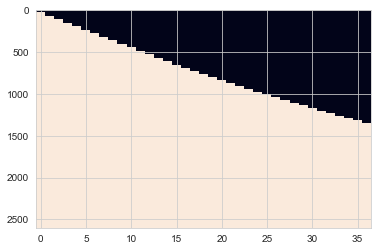

In [113]:
angle_mask = 1 * (angles < 38)
plt.imshow(angle_mask.T, aspect='auto')
angle_filt_gath = nmo_corr_gath * angle_mask.T # creating the clipped gather (still in the offset domain)

In [ ]:
calc_angles()

## Here I am linearly interpolating between the Vnmo points and then using a Savitzky–Golay filter ([information here](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter)) in order to smooth the results. This will help get rid of sharp jumps when we calculate the incidence angle of the NMO corrected reflections.

C:\Users\Thomas Cowan\.conda\envs\geocomp\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


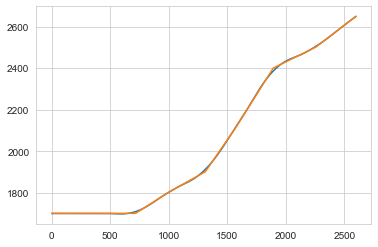

In [114]:
f1 = interp1d(twt_vnmo,
                  vnmo_correct, 
                  fill_value='extrapolate', kind='linear')
vnmo_usr_interp = f1(data['twt'])

from scipy.signal import savgol_filter

vnmo_corr_interp_savgol_filt = savgol_filter(vnmo_usr_interp, 501,3)
plt.plot(vnmo_corr_interp_savgol_filt)
plt.plot(vnmo_usr_interp)


depth = (vnmo_corr_interp_savgol_filt * data['twt']) / 2
angles = np.array([np.degrees(np.arctan(off / (vnmo_corr_interp_savgol_filt * data['twt']))) for off in data['offsets']])


In [210]:
v_int = vel[6000,:] * 1e3
v_int_twt = range(v_int.shape[0]) * data['dt'] 

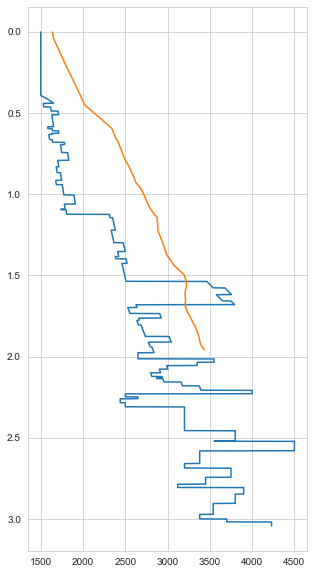

In [226]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,10))
plt.plot(v_int, v_int_twt)
plt.plot(rms, v_int_twt[:len(rms)])
plt.gca().invert_yaxis()

In [225]:
v_sq = np.power(v_int,2)
N = 1000
rms = np.sqrt(np.convolve(v_sq, np.ones((N,))/N, mode='valid'))

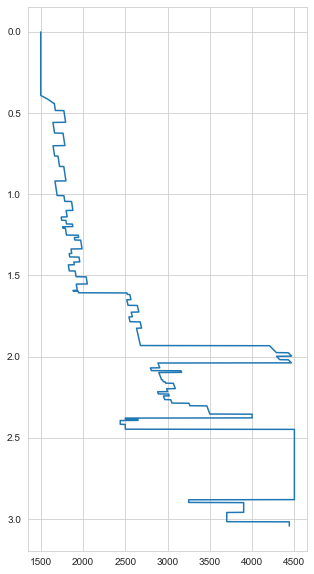

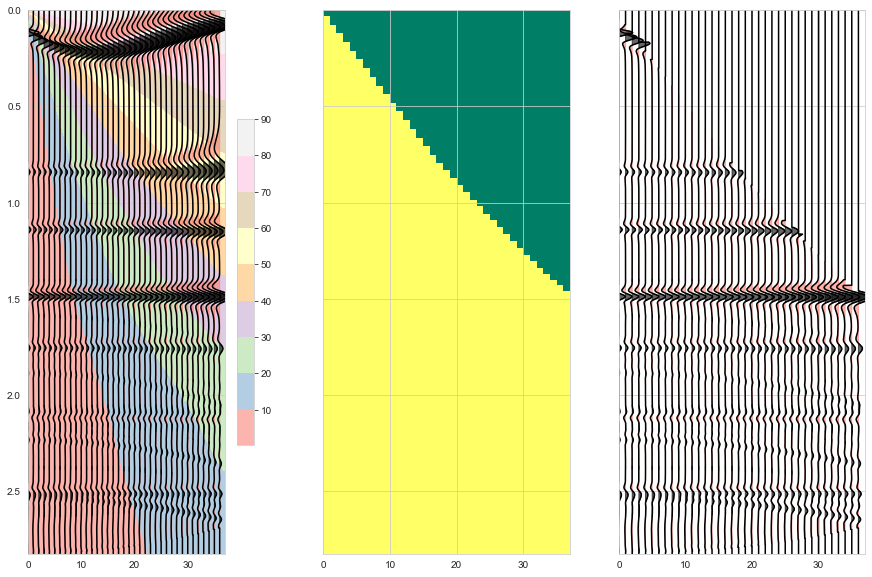

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,10), sharey=True, sharex=True)

for i,wig in enumerate(nmo_corr_gath.T):
    ax1.plot(wig * gain + i, twt, color='k')
    ax1.fill_betweenx(twt, i, wig * gain + i, where=wig * gain + i > i, color='k', alpha=0.6)
    ax1.fill_betweenx(twt, i, wig * gain + i, where=wig * gain + i < i, color='salmon', alpha=0.6)
im = ax1.imshow(angles.T, aspect = 'auto', alpha=1, extent=[0,37,twt.max(), 0], cmap='Pastel1', vmax=90, interpolation='bicubic')
plt.colorbar(im, ax=ax1, shrink=0.6)
ax1.set_ylim(twt.max(),0)
ax1.set_xlim(0,37)

im = ax2.imshow(angle_mask.T, aspect = 'auto', alpha=1, extent=[0,37,twt.max(), 0],
                cmap='summer', vmax=1)

for i,wig in enumerate(angle_filt_gath.T):
    ax3.plot(wig * gain + i, twt, color='k')
    ax3.fill_betweenx(twt, i, wig * gain + i, where=wig * gain + i > i, color='k', alpha=0.6)
    ax3.fill_betweenx(twt, i, wig * gain + i, where=wig * gain + i < i, color='salmon', alpha=0.6)



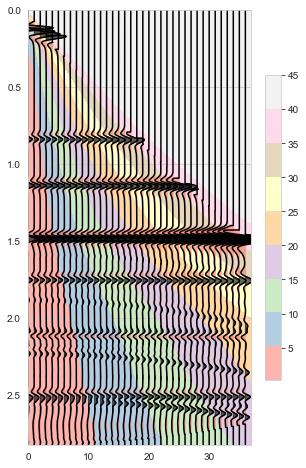

In [56]:
gain=10
plt.figure(figsize=(5,8))

for i,wig in enumerate(angle_filt_gath.T):
    plt.plot(wig * gain + i, twt, color='k')
    plt.fill_betweenx(twt, i, wig * gain + i, where=wig * gain + i > i, color='k', alpha=0.6)
    plt.fill_betweenx(twt, i, wig * gain + i, where=wig * gain + i < i, color='salmon', alpha=0.6)
plt.gca().invert_yaxis()
plt.imshow(angles.T, aspect = 'auto', alpha=1, extent=[0,37,twt.max(), 0], cmap='Pastel1', vmax=45, interpolation='bicubic')
plt.colorbar(shrink=0.7, )

In [112]:
interact_manual(interact_plot,
            v0=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=1700),
            v1=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=1700),
            v2=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=1800),
            v3=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=1900),
            v4=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=2100),
            v5=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=2400),
            v6=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=2500),
            v7=FloatSlider(min=vnmo_trial_vels.min(), max=vnmo_trial_vels.max(), step=50, value=2650)
            )

NameError: name 'interact_plot' is not defined

You can see from the above Dix interval velocity looks very similar to the true velocities of the earth model which generated the synthetic CMP we are analyzing.

In [111]:
from bruges import transform
sns.set_style('whitegrid')
plt.figure(figsize=(4,10))

true_vel, twt_trans = transform.depth_to_time(cmp_vel_mod[:,1], cmp_vel_mod[:,1], dz=10, dt=0.001, return_t=True)
plt.plot(true_vel, twt_trans, label='Dix Interval Velocity')
plt.plot(dix_vint_blkd, np.arange(0,t_basis.max(),dt), label='Actual Velocity')
plt.ylim(0,2.6)
plt.gca().invert_yaxis()
plt.ylabel('TWT (s)')
plt.xlabel('Velocity (m/s)')
plt.legend(loc=1, frameon=True)

NameError: name 'cmp_vel_mod' is not defined

<Figure size 288x720 with 0 Axes>

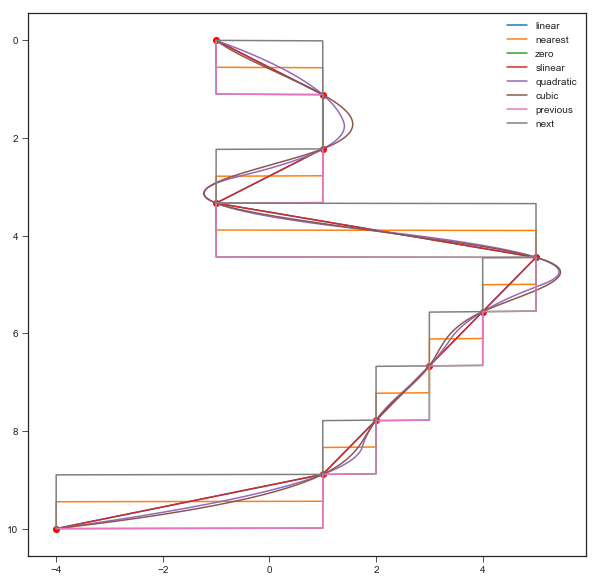

In [391]:
x = np.linspace(0,10,10)
y = np.array([-1,1,1,-1,5,4,3,2,1,-4])

x_new = np.linspace(0,10,1000)

interp_type = ['linear', 'nearest','zero', 'slinear','quadratic', 'cubic','previous', 'next']


    
plt.figure(figsize=(10,10))
for interpl in interp_type:
    z = interp1d(x,y,kind=interpl,)
    zz = z(x_new)
    plt.plot(zz,x_new, label=interpl)
    
plt.scatter(y,x,color='r') 
plt.gca().invert_yaxis()
plt.legend()

array([650, 300, 400, 400, 600, 600, 500])

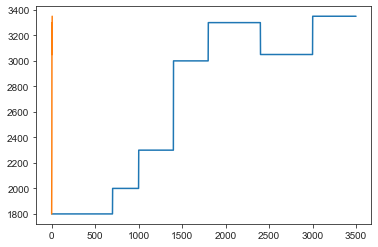

In [100]:
plt.plot(real_vel)
def rms(v,layer):
    l_diff = np.diff(layer)
    rms = [np.sqrt(np.sum(v**2 / l) * np.sum(l)) for v,l in zip(v, layer)]
    return rms
interface_depths = [50, 700, 1000, 1400, 1800, 2400, 3000,3500]
int_vels = [1800, 2000, 2300, 3000, 3300, 3050, 3350]
    
# rms = rms(int_vels, interface_depths)
# plt.plot(interface_depths[:-2],rms(int_vels))
plt.plot(rms)
np.diff(interface_depths)

array([0.00000000e+00, 1.08692589e-03, 2.17385177e-03, ...,
       2.68905464e+00, 2.69014157e+00, 2.69122849e+00])

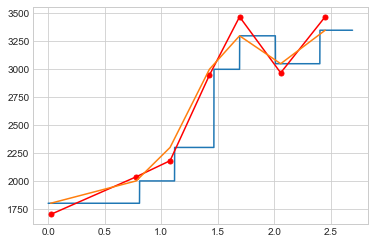

In [244]:
vrms = [1700,1700,1800,1900,2100,2400,2500,2650]
real_vel, twt_vel_mod = vel_mod()
twt_vrms = np.append(twt_vel_mod, twt.max())
interp_type = ['linear', 'nearest','zero', 'slinear','quadratic', 'cubic','previous', 'next']


def dix_eq(vrms, twt):
    int_vel = [np.sqrt((twt[i] * vrms[i]**2 - twt[i-1] * vrms[i-1]**2) / (twt[i] - twt[i-1])) for i in range(1,len(vrms))]
    return int_vel

v_int = dix_eq(vrms, twt_vrms)


# z = interp1d(twt_vrms[:-2],v_int,kind='previous')
# v_int_interp = z(x_new)
# plt.plot(zz,x_new, label=interpl)

t_basis, real_vel_twt = depth_to_time(real_vel, real_vel, dz=1.04,dt=dt,return_t=True)
# x_new=np.linspace(0,twt_vrms[-2],num=len(real_vel_twt))
plt.plot(real_vel_twt, t_basis)
plt.plot(twt_vrms[:-1], dix_eq(vrms, twt_vrms),'.-r', markersize=10)
plt.plot(twt_vel_mod, int_vels)
# plt.plot(twt_vel_mod_1, int_vels)

# plt.plot(x_new, v_int_interp)

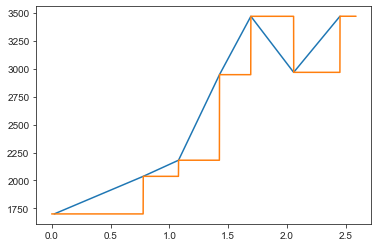

In [90]:
real_vel, twt_vel_mod = vel_mod()
real_vel_twt, t_basis = depth_to_time(real_vel, real_vel, dz=1, dt=data['dt'], return_t=True)
real_vel_twt = real_vel_twt[:data['cmp_geom_sprd'].shape[0]]
t_basis = t_basis[:data['cmp_geom_sprd'].shape[0]]

vnmo_user = [1700,1700,1800,1900,2100,2400,2500,2650]
dix_vint = dix_eq(vnmo_user, np.append(twt_vel_mod, data['twt'].max()))
dix_vint = np.append(dix_vint, dix_vint[-1])
f2 = interp1d(np.append(twt_vel_mod, data['twt'].max()),dix_vint, kind='previous', fill_value='extrapolate')
y_new = np.arange(0,t_basis.max(), data['dt'])
dix_vint_blkd = f2(y_new)

_, t = vel_mod()

plt.plot(t, dix_vint[:-1])
plt.plot()
plt.plot(np.arange(0,t_basis.max(),data['dt']), dix_vint_blkd)
# plt.plot(real_vel_twt, t_basis)

In [110]:
int_vel_twt = np.ones_like(data['cmp_geom_sprd']) * 


    

In [102]:
def v_rms(v,twt):
    t_diff = np.diff(twt)
#     vrms = [np.sqrt((v[i+1]**2 * t_diff[i+1] + v[i]**2 * t_diff[i]) / (t_diff[i+1] + t_diff[i])) for i in np.arange(6)]
#     vrms = np.cumsum(vrms)
    print(t_diff)
    rms = np.sqrt([np.sum((v[i]**2 * t_diff[i]) / np.sum(t_diff[i])) for i in range(len(t_diff))])
    print(rms)
    return rms

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
%matplotlib inline

In [103]:
test_mat = np.zeros((100,100))


[0.00108734 0.00108734 0.00108734 ... 0.00108734 0.00108734 0.00108734]


IndexError: index 8 is out of bounds for axis 0 with size 8

In [62]:
for i in range(4):
    step = int(test_mat.shape[0] / 4)
    test_mat[step * (i - 1):step*i, 30:32] = i + 1 * step
    print(step*i)
for i in range(6):
    step = int(test_mat.shape[0] / 6)
    test_mat[step * (i - 1):step*i, 60:62] = i + 1 * step

0
25
50
75


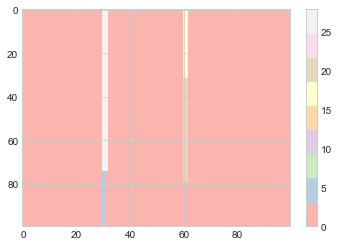

In [63]:
plt.imshow(test_mat, aspect='auto', cmap='Pastel1')
plt.colorbar()

In [65]:
from scipy import interpolate
x = np.arange(-5.01, 5.01, 0.25)
y = np.arange(-5.01, 5.01, 0.25)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2+yy**2)
f = interpolate.interp2d(x, y, z, kind='cubic')

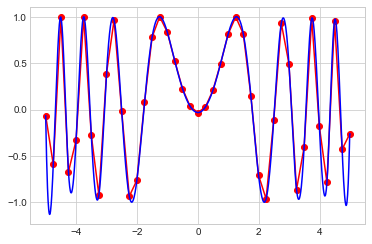

In [68]:
xnew = np.arange(-5.01, 5.01, 1e-2)
ynew = np.arange(-5.01, 5.01, 1e-2)
znew = f(xnew, ynew)
plt.plot(x, z[0, :], 'ro-', xnew, znew[0, :], 'b-')
plt.show()

In [67]:
vel_model = np.load(r"C:\Users\Thomas Cowan\Documents\GitHub\geotools\toys\devito_WSL\data\anticline_broad_vp_faults_5mres_20mflt.npy")

TypeError: 'list' object is not callable

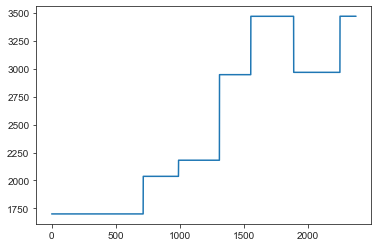

In [101]:
plt.plot(dix_vint_blkd)
plt.plot(rms(dix_vint_blkd, 300))

In [106]:
vnmo_sq = np.ones_like(data['cmp_geom_sprd']) * (dix_vint_blkd**2).reshape(data['cmp_geom_sprd'].shape[0],1)

ValueError: cannot reshape array of size 2380 into shape (2600,1)

In [174]:
file = r"C:\Users\Thomas Cowan\Documents\GitHub\geotools\toys\data\vp_marmousi-ii.segy"
with segyio.open(file) as f:
    vel_model = segyio.tools.cube(f)

RuntimeError: unable to find sorting.

In [175]:
with segyio.open(file, ignore_geometry=True) as f:
    vel = np.zeros([len(f.trace),len(f.trace[1])])
    for i in range(len(vel)):
        vel[i] = f.trace[i]

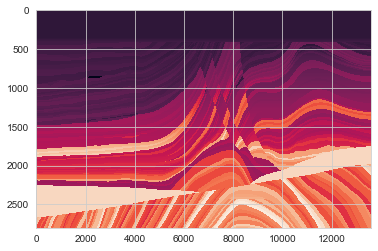

In [176]:
plt.imshow(vel.T, aspect='auto')

In [228]:
t = reflection_time_vectorized(data['cmp_'])

AttributeError: 'list' object has no attribute 'shape'